In [2]:
import numpy as np
def get_box_size(d2_box):
    width = max(d2_box[1][0]-d2_box[0][0], 1)
    height = max(d2_box[1][1]-d2_box[0][1], 1)
    return width, height

def calc_theta_ray(width, box_2d, proj_matrix):#透過跟2d bounding box 中心算出射線角度
    fovx = 2 * np.arctan(width / (2 * proj_matrix[0][0]))
    center = (box_2d[1][0] + box_2d[0][0]) / 2
    dx = center - (width / 2)

    mult = 1
    if dx < 0:
        mult = -1
    dx = abs(dx)
    angle = np.arctan( (2*dx*np.tan(fovx/2)) / width )
    angle = angle * mult

    return angle
def calc_depth_with_alpha_theta(img_W, box_2d, cam_to_img, obj_W, obj_L, alpha, trun=0.0):
    fovx = 2 * np.arctan(img_W / (2 * cam_to_img[0][0]))
    box_W = get_box_size(box_2d)[0] / (1-trun) #assume truncate related to W only
    visual_W = abs(obj_L*np.cos(alpha)) + abs(obj_W*np.sin(alpha))
    theta_ray = calc_theta_ray(img_W, box_2d, cam_to_img)
    visual_W /= abs(np.cos(theta_ray)) #new added !
    Wview = (visual_W)*(img_W/box_W) #box_W =obj_pixel
    depth = Wview/2 / np.tan(fovx/2)
    return depth

def calc_depth_by_height(img_H, box_2d, cam_to_img, obj_H):
    fovy = 2 * np.arctan(img_H / (2 * cam_to_img[1][1])) #radius
    box_H = get_box_size(box_2d)[1]
    Hview = obj_H*(img_H/box_H) 
    depth = Hview/2 / np.tan(fovy/2)

    return depth

def get_box_center(d2_box):
    return [(d2_box[0][0]+d2_box[1][0])//2, (d2_box[0][1]+d2_box[1][1])//2]
def get_calibration_cam_to_image(cab_f):
    for line in open(cab_f):
        if 'P2:' in line:
            cam_to_img = line.strip().split(' ')
            cam_to_img = np.asarray([float(number) for number in cam_to_img[1:]])
            cam_to_img = np.reshape(cam_to_img, (3, 4))
            return cam_to_img
    file_not_found(cab_f)
    
def file_not_found(filename):
    print("\nError! Can't read calibration file, does %s exist?"%filename)
    exit()


In [3]:
def box_depth_error_calculation(depth_labels, depth_Calcs, out_range=10):
    class_GT = np.copy(depth_labels)
    print(f'num of Car:', class_GT.shape[0])
    class_cal = np.copy(depth_Calcs)
    for depth in [0, 10, 20, 30, 40, 50]:
        class_GT_depth = class_GT[np.logical_and(class_GT >= depth, class_GT < depth+10.)]
        print(f'\tnum of depth {depth}-{depth+10}:', class_GT_depth.shape[0], end=' ')
        class_cal_depth = class_cal[np.logical_and(class_GT >= depth, class_GT < depth+10.)]
        cal_delta = abs(class_GT_depth - class_cal_depth)
        print(f'\tabs_delta mean:{cal_delta.mean():.3f}m, Out of {out_range}m: {cal_delta[cal_delta>=out_range].shape[0]}')
    # after 60 m
    class_GT_depth = class_GT[class_GT >= 60.]
    print(f'\tnum of depth {depth+10}+:', class_GT_depth.shape[0], end='   ')
    class_cal_depth = class_cal[class_GT >= 60.]
    cal_delta = abs(class_GT_depth - class_cal_depth)
    print(f'\tabs_delta mean:{cal_delta.mean():.3f}m, Out of {out_range}m: {cal_delta[cal_delta>=out_range].shape[0]}')
    total = abs(class_GT-class_cal)
    print(f'[Total] mean:{total.mean():.3f}, std:{total.std():.3f}')

In [4]:
import os
img_root = "Dataset/KITTI/training/image_2/"
label_root = 'Dataset/KITTI/training/label_2/'
calib_root = "Dataset/KITTI/training/calib/"
images=[]
labels=[]
calibs=[]
for filename in  sorted(os.listdir(img_root)):
    images.append(img_root+filename)
for label_name in sorted(os.listdir(label_root)):
    labels.append(label_root+label_name)
for calib_file in sorted(os.listdir(calib_root)):
    calibs.append(calib_root+calib_file)


depth_basic 57.379426619047614 depth_alpha 58.86153458440231 depth_gt 58.49
depth_basic 30.829338090909086 depth_alpha 33.734472344781736 depth_gt 34.38
depth_basic 10.998196009708737 depth_alpha 11.622457112579642 depth_gt 13.22
depth_basic 34.68036041935484 depth_alpha 38.02852853334441 depth_gt 38.26
depth_basic 49.7861013 depth_alpha 50.95094700383014 depth_gt 51.17
depth_basic 29.25901504878049 depth_alpha 31.585196871862912 depth_gt 31.73
depth_basic 17.663977868852456 depth_alpha 19.913909493618714 depth_gt 19.72
depth_basic 36.56978690909091 depth_alpha 38.80114531473809 depth_gt 38.44
depth_basic 23.23351394 depth_alpha 23.99415610706971 depth_gt 25.01
depth_basic 45.91603545454545 depth_alpha 47.43523922709535 depth_gt 47.55
depth_basic 58.524724555555544 depth_alpha 61.002288264233506 depth_gt 60.52
depth_basic 5.869503569948186 depth_alpha 7.637517278723541 depth_gt 7.86
depth_basic 12.478357870588235 depth_alpha 14.255424925355028 depth_gt 14.44
depth_basic 31.451643333333

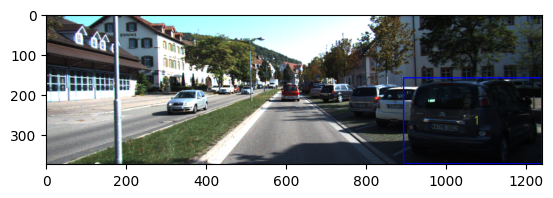

depth_basic 8.600729384000001 depth_alpha 10.363997787682987 depth_gt 10.4
depth_basic 11.96903714117647 depth_alpha 13.966754722061273 depth_gt 14.02
depth_basic 49.42533245 depth_alpha 51.172309559645804 depth_gt 50.9
depth_basic 16.060032677419354 depth_alpha 18.404390857723758 depth_gt 18.66
depth_basic 22.874280276595744 depth_alpha 24.713733163251057 depth_gt 24.75
depth_basic 48.198718359999994 depth_alpha 51.78459031429143 depth_gt 52.04
depth_basic 58.92557883333333 depth_alpha 60.818258870428444 depth_gt 59.96
depth_basic 5.8998662762430945 depth_alpha 5.3564315854232 depth_gt 7.17
Image idx 39
GT 7.17, Trun0:6.70, T:5.36, Trun:0.2, H 5.90, Ry:1.55, alpha:1.9


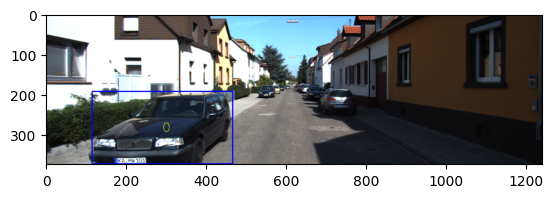

depth_basic 14.430753999999999 depth_alpha 16.170027449215286 depth_gt 16.67
depth_basic 31.335351542857143 depth_alpha 33.91102624227008 depth_gt 33.82
depth_basic 27.238048175 depth_alpha 29.005645117662496 depth_gt 29.48
depth_basic 32.694677031249995 depth_alpha 35.35489197466644 depth_gt 35.37
depth_basic 39.81819159259259 depth_alpha 41.99179260241335 depth_gt 41.75
depth_basic 41.05300706896551 depth_alpha 41.659895398833825 depth_gt 44.49
depth_basic 11.842629641304347 depth_alpha 13.721809761868187 depth_gt 13.93
depth_basic 12.478357870588235 depth_alpha 15.076062854125277 depth_gt 15.21
depth_basic 19.981043999999997 depth_alpha 21.899791714549146 depth_gt 21.96
depth_basic 24.910230119047615 depth_alpha 27.11330627277697 depth_gt 27.06
depth_basic 30.064070833333332 depth_alpha 31.51149057683859 depth_gt 31.88
depth_basic 38.067333827586204 depth_alpha 41.3118943435192 depth_gt 41.53
depth_basic 24.692623511111112 depth_alpha 25.105084804196903 depth_gt 26.76
depth_basic 5.

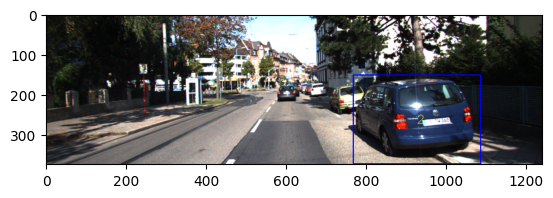

depth_basic 13.974084569620253 depth_alpha 15.091845777618945 depth_gt 15.65
depth_basic 30.380534736842105 depth_alpha 31.89310736262854 depth_gt 32.3
depth_basic 24.471693617021277 depth_alpha 24.384711614988966 depth_gt 26.54
depth_basic 9.99659125 depth_alpha 11.87385201325145 depth_gt 12.25
depth_basic 20.846824 depth_alpha 23.410655362462055 depth_gt 23.68
depth_basic 23.16313777777778 depth_alpha 24.973573880594817 depth_gt 25.13
depth_basic 46.869411199999995 depth_alpha 46.24075132330173 depth_gt 47.7
depth_basic 15.235455522388058 depth_alpha 17.68773949963891 depth_gt 17.75
depth_basic 19.62582544 depth_alpha 20.02255553887768 depth_gt 21.55
depth_basic 12.025628333333332 depth_alpha 13.73093982138443 depth_gt 13.75
depth_basic 7.319195374100719 depth_alpha 9.058746593864765 depth_gt 9.53
depth_basic 12.421408506329115 depth_alpha 14.30491134889415 depth_gt 14.89
depth_basic 15.507675940298505 depth_alpha 17.22077373181635 depth_gt 17.23
depth_basic 12.501060151162791 depth_

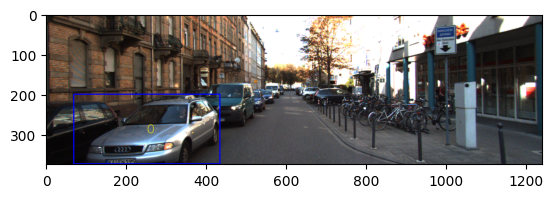

depth_basic 28.861508 depth_alpha 31.38399980208962 depth_gt 31.5
depth_basic 24.351897375000004 depth_alpha 25.80466602729165 depth_gt 25.95
depth_basic 38.106209781249994 depth_alpha 38.88038096061761 depth_gt 39.79
depth_basic 14.93887914084507 depth_alpha 16.65913436465426 depth_gt 16.53
depth_basic 61.3307045 depth_alpha 62.713119951065174 depth_gt 62.51
depth_basic 17.8719338 depth_alpha 17.905892965855394 depth_gt 19.58
depth_basic 23.118656918367346 depth_alpha 24.753819574468405 depth_gt 25.33
depth_basic 9.974197617647057 depth_alpha 12.440152382393917 depth_gt 12.67
depth_basic 29.971566000000003 depth_alpha 30.226063717501106 depth_gt 32.6
depth_basic 14.149635415584415 depth_alpha 16.626329389384 depth_gt 16.67
depth_basic 20.596621618181818 depth_alpha 22.53956948358577 depth_gt 22.81
depth_basic 25.86976631707317 depth_alpha 27.886801403552273 depth_gt 28.33
depth_basic 37.32091551724138 depth_alpha 38.79563049395581 depth_gt 39.62
depth_basic 8.699390709219859 depth_alp

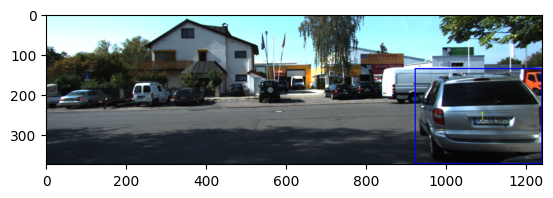

depth_basic 22.720761617021278 depth_alpha 25.609001944348794 depth_gt 25.53
depth_basic 22.645183199999998 depth_alpha 25.461185268008467 depth_gt 25.43
depth_basic 30.13480982352941 depth_alpha 32.11225431252443 depth_gt 32.39
depth_basic 25.33771923255814 depth_alpha 27.081611887888325 depth_gt 27.59
depth_basic 42.2970375862069 depth_alpha 42.88678442099807 depth_gt 44.05
depth_basic 25.724387565217388 depth_alpha 28.05067804044646 depth_gt 28.28
depth_basic 22.07905362 depth_alpha 25.288897423807573 depth_gt 25.31
depth_basic 14.868049575757576 depth_alpha 16.026243740026988 depth_gt 17.14
depth_basic 20.127104263157893 depth_alpha 22.82554068035931 depth_gt 22.83
depth_basic 22.062402749999997 depth_alpha 24.023985800666264 depth_gt 24.07
depth_basic 44.795465541666665 depth_alpha 46.98985996627104 depth_gt 46.96
depth_basic 5.7270032690582955 depth_alpha 7.265598464864614 depth_gt 7.85
depth_basic 21.39295987719298 depth_alpha 23.04460243052573 depth_gt 23.57
depth_basic 26.6281

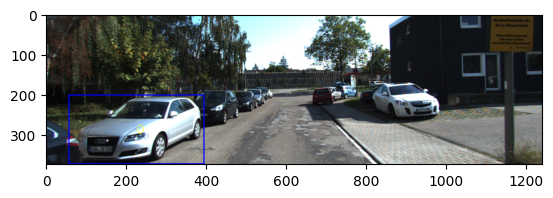

depth_basic 11.157799484536083 depth_alpha 12.811381413535564 depth_gt 13.43
depth_basic 12.077913673913043 depth_alpha 13.953193501566314 depth_gt 14.17
depth_basic 18.296134535714284 depth_alpha 20.141740080603494 depth_gt 20.44
depth_basic 22.430411108695647 depth_alpha 25.233588311092014 depth_gt 25.45
depth_basic 22.80059132 depth_alpha 24.641377943308473 depth_gt 24.95
depth_basic 27.238048175 depth_alpha 29.33036314919428 depth_gt 29.24
depth_basic 31.396640459459462 depth_alpha 32.625026408397126 depth_gt 33.03
depth_basic 40.2396025 depth_alpha 42.34573905955863 depth_gt 42.88
depth_basic 36.31739756666666 depth_alpha 38.90002261731892 depth_gt 38.75
depth_basic 25.975357199999998 depth_alpha 27.955781720423243 depth_gt 27.99
depth_basic 43.89354341666666 depth_alpha 43.60282462776126 depth_gt 44.77
depth_basic 17.87690420895522 depth_alpha 18.38385749597136 depth_gt 19.73
depth_basic 45.17453426086956 depth_alpha 46.97554399367884 depth_gt 48.73
depth_basic 35.8238312 depth_a

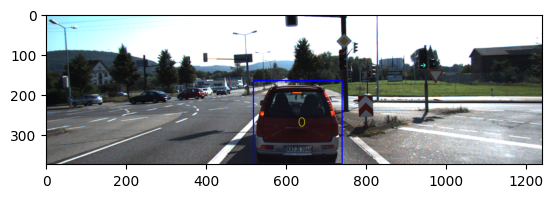

depth_basic 31.922577030303025 depth_alpha 34.86082324175294 depth_gt 34.57
depth_basic 34.27304075 depth_alpha 37.928724448575686 depth_gt 37.65
depth_basic 37.24065548387097 depth_alpha 38.687875889783435 depth_gt 38.47
depth_basic 50.507639 depth_alpha 54.401142327061685 depth_gt 53.93
depth_basic 12.556630103896104 depth_alpha 15.296554648218603 depth_gt 15.6
depth_basic 10.976584159574466 depth_alpha 12.479348615490236 depth_gt 13.23
depth_basic 40.69472628 depth_alpha 42.59220140101709 depth_gt 42.84
depth_basic 44.124805499999994 depth_alpha 45.09606824729622 depth_gt 45.83
depth_basic 42.137801679999995 depth_alpha 43.08601019845226 depth_gt 43.86
depth_basic 41.3496605 depth_alpha 42.80267785428453 depth_gt 43.09
depth_basic 43.292262 depth_alpha 46.64929719465249 depth_gt 46.35
depth_basic 69.74864433333332 depth_alpha 71.65319297566502 depth_gt 72.14
depth_basic 67.644159375 depth_alpha 73.96888359320327 depth_gt 72.86
depth_basic 17.020889333333336 depth_alpha 19.5352461297

In [6]:
import glob
import os
import cv2
import matplotlib.pyplot as plt
# from library.File import * # get_calibration_cam_to_image
# from library.ron_utils import *

# img_root = "Dataset/KITTI/training/image_2"
# label_root = 'Dataset/KITTI/training/label_2'
# calib_root = "Dataset/KITTI/training/calib"

# images = glob.glob(os.path.join(img_root, '*.png'), recursive=True)
# labels = glob.glob(os.path.join(label_root, '*.txt'), recursive=True)
# calibs = glob.glob(os.path.join(calib_root, '*.txt'), recursive=True)

Dimensions = list()
Rys = list()
Alphas = list()
Box_2Ds = list()
Box_width = list()
Box_height = list()
Truncates = list()
depth_GT = list()
depth_H = list()
depth_T = list()
depth_basic_list=list()

for i in range(len(images)-7350):
    img = cv2.imread(images[i])
    img_H = img.shape[0]
    img_W = img.shape[1] # H, W, 3
    cam_to_img = get_calibration_cam_to_image(calibs[i])
    with open(labels[i]) as f:
        lines = f.readlines()
        for idx, line in enumerate(lines):
            elements = line[:-1].split()
            if elements[0] != 'Car':
                continue
            for j in range(1, len(elements)):
                elements[j] = float(elements[j])
            truncate = elements[1] # 0~1
            occluded = int(elements[2]) # 0:visible, 1:partly, 2:largely, 3:unknown
            
            # Moderate in monodle   # 朝向正前或正後
            # 多少物體在圖片邊界之外 how much of an object locates beyond image boundary
            if truncate<=0.3 and occluded<=1:
                top_left = (int(round(elements[4])), int(round(elements[5])))
                btm_right = (int(round(elements[6])), int(round(elements[7])))
                box_2d = [top_left, btm_right]
                d2_center = get_box_center(box_2d)
                box_w, box_h = get_box_size(box_2d)
                dim = np.array([elements[8], elements[9], elements[10]], dtype=np.double) # Height, Width, Length
                obj_H = elements[8]
                obj_W = elements[9] #Dimension[1]
                obj_L = elements[10]#Dimension[2]
                Location = [elements[11], elements[12], elements[13]]  # x, y, z
                depth_label = elements[13] #Location[2]
                alpha = elements[3]
                ry = elements[14]
                
                # append info to  list
                Truncates.append(truncate)
                Box_2Ds.append(box_2d)
                Dimensions.append(dim)
                Box_width.append(box_w)
                Box_height.append(box_h)
                Rys.append(ry)
                Alphas.append(alpha)
                
                # calc depth
                depth_height = calc_depth_by_height(img_H, box_2d, cam_to_img, obj_H)
                depth_theta = calc_depth_with_alpha_theta(img_W, box_2d, cam_to_img, obj_W, obj_L, alpha, truncate)
                
                depth_basic=cam_to_img[0][0]*obj_H / box_h
                print('depth_basic',depth_basic,'depth_alpha',depth_theta,'depth_gt',depth_label)

                depth_GT.append(depth_label) 
                depth_H.append(depth_height)
                depth_T.append(depth_theta)
                depth_basic_list.append(depth_basic)
                depth_trun0 = calc_depth_with_alpha_theta(img_W, box_2d, cam_to_img, obj_W, obj_L, alpha, 0)
                # visualize truncation is worse than no truncation in 10m
                if depth_label <= 10 and abs(depth_theta-depth_label) > abs(depth_trun0-depth_label):
                    print(f'Image idx {i}')
                    d2_center = get_box_center(box_2d)
                    cv2.rectangle(img, box_2d[0], box_2d[1], color=(255,0,0), thickness=2)
                    cv2.putText(img, f'{idx}', (d2_center[0], d2_center[1]+10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 1, cv2.LINE_AA)
                    print(f'GT {depth_label:.2f}, Trun0:{depth_trun0:.2f}, T:{depth_theta:.2f}, Trun:{truncate}, H {depth_height:.2f}, Ry:{ry}, alpha:{alpha}')
                    
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    plt.imshow(img)
                    plt.show()
                
print('Total:', len(depth_GT)) #(19250 truncate<=0.3 and occluded<=1), 28742 (all)
depth_GT = np.array(depth_GT)
depth_basic_list=np.array(depth_basic_list)
Rys = np.array(Rys)
Alphas = np.array(Alphas)
Box_2Ds = np.array(Box_2Ds)
Box_width = np.array(Box_width)
Box_height = np.array(Box_height)
Dimensions = np.array(Dimensions) # Height, Width, Length
depth_H = np.array(depth_H)
depth_T = np.array(depth_T)
Truncates = np.array(Truncates)

num of Car: 317
	num of depth 0-10: 20 	abs_delta mean:0.731m, Out of 5m: 0
	num of depth 10-20: 82 	abs_delta mean:0.416m, Out of 5m: 0
	num of depth 20-30: 72 	abs_delta mean:0.459m, Out of 5m: 0
	num of depth 30-40: 52 	abs_delta mean:0.368m, Out of 5m: 0
	num of depth 40-50: 50 	abs_delta mean:0.692m, Out of 5m: 0
	num of depth 50-60: 20 	abs_delta mean:0.641m, Out of 5m: 0
	num of depth 60+: 21   	abs_delta mean:0.902m, Out of 5m: 0
[Total] mean:0.528, std:0.537
delta>0:244, ==0:0, <0:73
max:2.886, min:-2.537


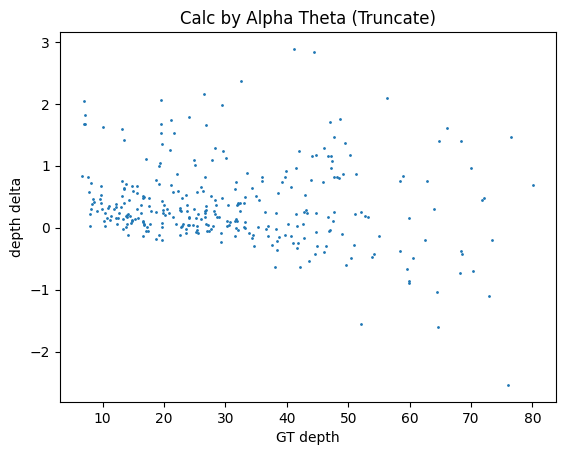

In [11]:
# GT - width_calc (with truncate)
box_depth_error_calculation(depth_GT, depth_T, out_range=5)
#plot
delta_theta = depth_GT - depth_T
print(f'delta>0:{delta_theta[delta_theta>0].shape[0]}, ==0:{delta_theta[delta_theta==0].shape[0]}, <0:{delta_theta[delta_theta<0].shape[0]}')
print(f'max:{(delta_theta.max()):.3f}, min:{(delta_theta.min()):.3f}')
plt.scatter(depth_GT, delta_theta, s=1)
plt.xlabel('GT depth')
plt.ylabel('depth delta')
plt.title('Calc by Alpha Theta (Truncate)')
plt.show()

num of Car: 317
	num of depth 0-10: 20 	abs_delta mean:1.807m, Out of 5m: 0
	num of depth 10-20: 82 	abs_delta mean:2.176m, Out of 5m: 0
	num of depth 20-30: 72 	abs_delta mean:2.312m, Out of 5m: 0
	num of depth 30-40: 52 	abs_delta mean:2.458m, Out of 5m: 0
	num of depth 40-50: 50 	abs_delta mean:2.491m, Out of 5m: 0
	num of depth 50-60: 20 	abs_delta mean:2.946m, Out of 5m: 1
	num of depth 60+: 21   	abs_delta mean:2.261m, Out of 5m: 2
[Total] mean:2.334, std:0.844
delta>0:316, ==0:0, <0:1
max:6.641, min:-2.301


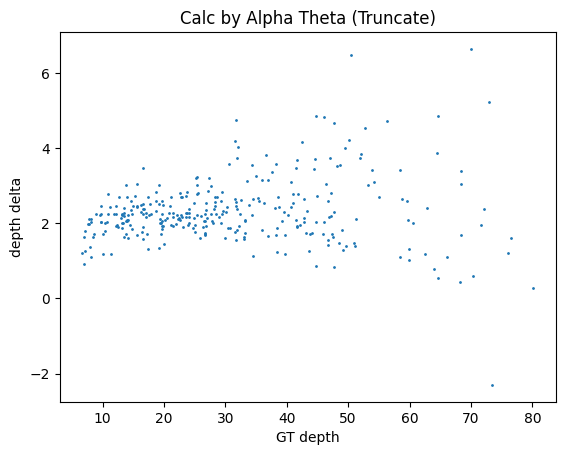

In [10]:
# GT - width_calc (with truncate)
box_depth_error_calculation(depth_GT, depth_H, out_range=5)
#plot
delta_theta = depth_GT - depth_H
print(f'delta>0:{delta_theta[delta_theta>0].shape[0]}, ==0:{delta_theta[delta_theta==0].shape[0]}, <0:{delta_theta[delta_theta<0].shape[0]}')
print(f'max:{(delta_theta.max()):.3f}, min:{(delta_theta.min()):.3f}')
plt.scatter(depth_GT, delta_theta, s=1)
plt.xlabel('GT depth')
plt.ylabel('depth delta')
plt.title('Calc by Alpha Theta (Truncate)')
plt.show()

num of Car: 317
	num of depth 0-10: 20 	abs_delta mean:1.807m, Out of 5m: 0
	num of depth 10-20: 82 	abs_delta mean:2.176m, Out of 5m: 0
	num of depth 20-30: 72 	abs_delta mean:2.312m, Out of 5m: 0
	num of depth 30-40: 52 	abs_delta mean:2.458m, Out of 5m: 0
	num of depth 40-50: 50 	abs_delta mean:2.491m, Out of 5m: 0
	num of depth 50-60: 20 	abs_delta mean:2.946m, Out of 5m: 1
	num of depth 60+: 21   	abs_delta mean:2.261m, Out of 5m: 2
[Total] mean:2.334, std:0.844
delta>0:316, ==0:0, <0:1
max:6.641, min:-2.301


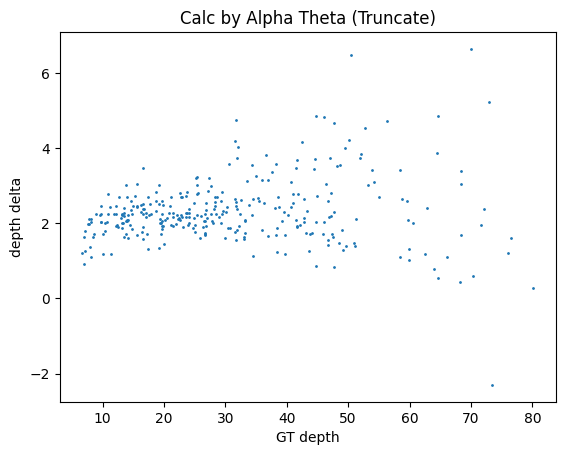

In [9]:
# GT - width_calc (with truncate)
box_depth_error_calculation(depth_GT, depth_basic_list, out_range=5)
#plot
delta_theta = depth_GT - depth_basic_list
print(f'delta>0:{delta_theta[delta_theta>0].shape[0]}, ==0:{delta_theta[delta_theta==0].shape[0]}, <0:{delta_theta[delta_theta<0].shape[0]}')
print(f'max:{(delta_theta.max()):.3f}, min:{(delta_theta.min()):.3f}')
plt.scatter(depth_GT, delta_theta, s=1)
plt.xlabel('GT depth')
plt.ylabel('depth delta')
plt.title('Calc by Alpha Theta (Truncate)')
plt.show()